<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [ ]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import urllib.request
import re

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.layers import Bidirectional

### Datos
Utilizaremos como dataset los sonetos de Shakespeare

In [ ]:
raw_html = urllib.request.urlopen('https://www.gutenberg.org/files/1041/1041-h/1041-h.htm')
raw_html = raw_html.read()

article_html = bs.BeautifulSoup(raw_html, 'lxml')

article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text

article_text = article_text.lower()

In [ ]:
article_text = article_text.replace('\n', '.') #Elimino los saltos de fila
article_text = article_text.replace(',.', '.') # Reemplazo ,. por .
article_text = article_text.replace(':.', '.')
article_text = article_text.replace(';.', '.')
article_text = article_text.replace('\xa0\xa0\xa0\xa0', '')
article_text = re.split(r"\r.", article_text) #Separo las oraciones

In [ ]:
df = pd.DataFrame(article_text)
df.drop(0)

,0
1,"from fairest creatures we desire increase,"
2,"that thereby beauty’s rose might never die,"
3,"but as the riper should by time decease,"
4,his tender heir might bear his memory:
5,"but thou, contracted to thine own bright eyes,"
...,...
2151,"which from love’s fire took heat perpetual,"
2152,"growing a bath and healthful remedy,"
2153,"for men diseas’d; but i, my mistress’ thrall,"
2154,"came there for cure and this by that i prove,"


In [ ]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 2156


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [ ]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.preprocessing.sequence import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [ ]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[1,0]
text

'  from fairest creatures we desire increase,'

In [ ]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['from', 'fairest', 'creatures', 'we', 'desire', 'increase']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [ ]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [ ]:
# Demos un vistazo
sentence_tokens[1:3]

[['from', 'fairest', 'creatures', 'we', 'desire', 'increase'],
 ['that', 'thereby', 'beauty’s', 'rose', 'might', 'never', 'die']]

In [ ]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [ ]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['from', 'fairest', 'creatures', 'we'],
 ['fairest', 'creatures', 'we', 'desire']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [ ]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [ ]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[4, 1, 2, 3], [1, 2, 3, 5]]

In [ ]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

2


In [ ]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

5


In [ ]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'fairest': 1, 'creatures': 2, 'we': 3, 'from': 4, 'desire': 5}


In [ ]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'creatures': 2, 'from': 1, 'fairest': 2, 'we': 2, 'desire': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [ ]:
# Vistazo a las primeras filas
df.loc[:15,0]

0                                                      
1            from fairest creatures we desire increase,
2           that thereby beauty’s rose might never die,
3              but as the riper should by time decease,
4                his tender heir might bear his memory:
5        but thou, contracted to thine own bright eyes,
6       feed’st thy light’s flame with self-substant...
7                 making a famine where abundance lies,
8         thyself thy foe, to thy sweet self too cruel:
9         thou that art now the world’s fresh ornament,
10                 and only herald to the gaudy spring,
11            within thine own bud buriest thy content,
12         and tender churl mak’st waste in niggarding:
13             pity the world, or else this glutton be,
14      to eat the world’s due, by the grave and thee..
15           when forty winters shall besiege thy brow,
Name: 0, dtype: object

In [ ]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'   from fairest creatures we desire increase,   that thereby beauty’s rose might never die,   but as the riper should by time decease,   his tender heir might bear his memory:   but thou, contracted to thine own bright eyes,   feed’st thy light’s flame with self-substantial fuel,   making a famine where abundance lies,   thyself thy foe, to thy sweet self too cruel:   thou that art now the world’s fresh ornament,   and only herald to the gaudy spring,   within thine own bud buriest thy content,   and tender churl mak’st waste in niggarding:   pity the world, or else this glutton be,   to eat the world’s due, by the grave and thee..   when forty winters shall besiege thy brow,   and dig deep trenches in thy beauty’s field,   thy youth’s proud livery so gazed on now,   will be a tatter’d weed of small worth held:   then being asked, where all thy beauty lies,   where all the treasure of thy lusty days;   to say, within thine own deep sunken eyes,   were an all-eating shame, and thriftle

In [ ]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['from',
 'fairest',
 'creatures',
 'we',
 'desire',
 'increase',
 'that',
 'thereby',
 'beauty’s',
 'rose',
 'might',
 'never',
 'die',
 'but',
 'as',
 'the',
 'riper',
 'should',
 'by',
 'time']

In [ ]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 17620


In [ ]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [ ]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['from', 'fairest', 'creatures', 'we'],
 ['fairest', 'creatures', 'we', 'desire'],
 ['creatures', 'we', 'desire', 'increase'],
 ['we', 'desire', 'increase', 'that'],
 ['desire', 'increase', 'that', 'thereby'],
 ['increase', 'that', 'thereby', 'beauty’s'],
 ['that', 'thereby', 'beauty’s', 'rose'],
 ['thereby', 'beauty’s', 'rose', 'might'],
 ['beauty’s', 'rose', 'might', 'never'],
 ['rose', 'might', 'never', 'die'],
 ['might', 'never', 'die', 'but'],
 ['never', 'die', 'but', 'as'],
 ['die', 'but', 'as', 'the'],
 ['but', 'as', 'the', 'riper'],
 ['as', 'the', 'riper', 'should'],
 ['the', 'riper', 'should', 'by'],
 ['riper', 'should', 'by', 'time'],
 ['should', 'by', 'time', 'decease'],
 ['by', 'time', 'decease', 'his'],
 ['time', 'decease', 'his', 'tender']]

In [ ]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[34, 511, 1374, 165],
 [511, 1374, 165, 214],
 [1374, 165, 214, 512],
 [165, 214, 512, 8],
 [214, 512, 8, 871],
 [512, 8, 871, 134],
 [8, 871, 134, 350],
 [871, 134, 350, 101],
 [134, 350, 101, 154],
 [350, 101, 154, 199],
 [101, 154, 199, 18],
 [154, 199, 18, 22],
 [199, 18, 22, 2],
 [18, 22, 2, 872],
 [22, 2, 872, 61],
 [2, 872, 61, 30],
 [872, 61, 30, 48],
 [61, 30, 48, 635],
 [30, 48, 635, 26],
 [48, 635, 26, 312]]

In [ ]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 17616


### 3 - Input y target

In [ ]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(17616, 3)
(17616,)


In [ ]:
# Palabras del vocabulario
tok.index_word

{1: 'and',
 2: 'the',
 3: 'to',
 4: 'my',
 5: 'of',
 6: 'i',
 7: 'in',
 8: 'that',
 9: 'thy',
 10: 'thou',
 11: 'with',
 12: 'for',
 13: 'is',
 14: 'not',
 15: 'love',
 16: 'a',
 17: 'me',
 18: 'but',
 19: 'thee',
 20: 'so',
 21: 'be',
 22: 'as',
 23: 'all',
 24: 'you',
 25: 'which',
 26: 'his',
 27: 'when',
 28: 'it',
 29: 'this',
 30: 'by',
 31: 'your',
 32: 'doth',
 33: 'do',
 34: 'from',
 35: 'on',
 36: 'or',
 37: 'no',
 38: 'have',
 39: 'then',
 40: 'what',
 41: 'are',
 42: 'if',
 43: 'more',
 44: 'mine',
 45: 'their',
 46: 'shall',
 47: 'sweet',
 48: 'time',
 49: 'will',
 50: 'they',
 51: 'eyes',
 52: 'beauty',
 53: 'nor',
 54: 'art',
 55: 'her',
 56: 'yet',
 57: 'heart',
 58: 'o',
 59: 'than',
 60: 'now',
 61: 'should',
 62: 'thine',
 63: 'can',
 64: 'make',
 65: 'he',
 66: 'one',
 67: 'hath',
 68: 'where',
 69: 'fair',
 70: 'still',
 71: 'how',
 72: 'him',
 73: 'true',
 74: 'eye',
 75: 'like',
 76: 'see',
 77: 'am',
 78: 'she',
 79: 'those',
 80: 'though',
 81: 'being',
 82: 's

In [ ]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

3225

In [ ]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [ ]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(17616, 3225)

### 4 - Entrenar el modelo

In [ ]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [ ]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

3225

###Modelo 1

In [ ]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(256,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(256))) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              16130     
                                                                 
 bidirectional (Bidirectiona  (None, 3, 128)           35840     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 128)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 3, 256)           263168    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 3, 256)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 3, 512)           1

In [ ]:
hist = model.fit(x_data, y_data, epochs=400, validation_split=0.02)

Epoch 1/400
540/540 [==============================] - 8s 16ms/step - loss: 1.8148 - accuracy: 0.5435 - val_loss: 38.8157 - val_accuracy: 0.0255
Epoch 2/400
540/540 [==============================] - 8s 15ms/step - loss: 1.8298 - accuracy: 0.5427 - val_loss: 38.5028 - val_accuracy: 0.0368
Epoch 3/400
540/540 [==============================] - 8s 16ms/step - loss: 1.7916 - accuracy: 0.5463 - val_loss: 39.3837 - val_accuracy: 0.0368
Epoch 4/400
540/540 [==============================] - 9s 16ms/step - loss: 1.8012 - accuracy: 0.5467 - val_loss: 39.4621 - val_accuracy: 0.0368
Epoch 5/400
540/540 [==============================] - 8s 16ms/step - loss: 1.7840 - accuracy: 0.5487 - val_loss: 39.0803 - val_accuracy: 0.0312
Epoch 6/400
540/540 [==============================] - 8s 15ms/step - loss: 1.7579 - accuracy: 0.5578 - val_loss: 39.9988 - val_accuracy: 0.0227
Epoch 7/400
540/540 [==============================] - 8s 15ms/step - loss: 1.7745 - accuracy: 0.5503 - val_loss: 39.0892 - val_ac

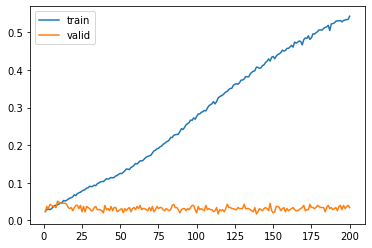

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

###Modelo 2

In [ ]:
model2 = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model2.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))
model2.add(Bidirectional(LSTM(64, return_sequences=True)))
model2.add(Dropout(0.3))
model2.add(Bidirectional(LSTM(128,return_sequences=True)))
model2.add(Dropout(0.1))
model2.add(Bidirectional(LSTM(128))) # La última capa LSTM no lleva return_sequences
model2.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model2.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 5)              16130     
                                                                 
 bidirectional_4 (Bidirectio  (None, 3, 128)           35840     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 3, 128)            0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 3, 256)           263168    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 3, 256)            0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 256)             

In [ ]:
hist = model2.fit(x_data, y_data, epochs=400, validation_split=0.2)

Epoch 1/400
441/441 [==============================] - 20s 18ms/step - loss: 6.8280 - accuracy: 0.0260 - val_loss: 6.6968 - val_accuracy: 0.0261
Epoch 2/400
441/441 [==============================] - 6s 13ms/step - loss: 6.4094 - accuracy: 0.0269 - val_loss: 6.8044 - val_accuracy: 0.0261
Epoch 3/400
441/441 [==============================] - 6s 14ms/step - loss: 6.2812 - accuracy: 0.0279 - val_loss: 6.8838 - val_accuracy: 0.0281
Epoch 4/400
441/441 [==============================] - 6s 14ms/step - loss: 6.1555 - accuracy: 0.0316 - val_loss: 7.0950 - val_accuracy: 0.0287
Epoch 5/400
441/441 [==============================] - 6s 15ms/step - loss: 6.0609 - accuracy: 0.0346 - val_loss: 7.2561 - val_accuracy: 0.0309
Epoch 6/400
441/441 [==============================] - 6s 13ms/step - loss: 5.9873 - accuracy: 0.0375 - val_loss: 7.2747 - val_accuracy: 0.0227
Epoch 7/400
441/441 [==============================] - 6s 13ms/step - loss: 5.9219 - accuracy: 0.0378 - val_loss: 7.5265 - val_accuracy

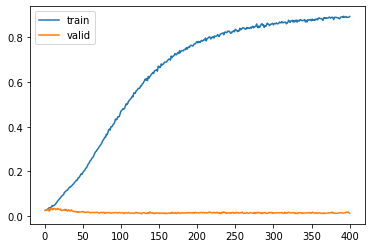

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [ ]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     |████████████████████████████████| 5.6 MB 30.2 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 1.1 MB 65.0 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 212 kB 77.7 MB/s 
     |████████████████████████████████| 140 kB 79.3 MB/s 
     |████████████████████████████████| 57 kB 5.7 MB/s 
     |████████████████████████████████| 2.3 MB 71.6 MB/s 
     |████████████████████████████████| 272 kB 75.9 MB/s 
     |████████████████████████████████| 84 kB 4.4 MB/s 
     |████████████████████████████████| 54 kB 4.1 MB/s 
     |████████████████████████████████| 271 kB 77.1 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 
     |████████████████████████████████| 144 kB 78.6 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 80 kB 10.4 MB/s 
     |████████████████████████████████| 68 kB 7.4 MB/s 
     |█████████████████████████

In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model2.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://18692.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7f73466eea50>,
 'http://127.0.0.1:7860/',
 'https://18692.gradio.app')

### 6 - Generación de secuencias nuevas

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [ ]:
input_text='but as the riper'

generate_seq(model2, tok, input_text, max_length=3, n_words=2)

'but as the riper now he'

### 7 - Conclusiones
*   A pesar de realizar cerca de 10 modelos diferentes, no se logró mejorar el resultado.
*   Se probaron modelos con varias capas, así como con y sin BRNN.
*   Se volvió a producir el overfitting en todos los casos.
*   Cada entrenamiento, tomó cerca de 1 hora.
*   Una posibilidad sería utilizar modelos preentrenados en busca de mejorar los resultados.